# Trends in Caribbean atmospheric stability

Plot trends in convective available potential energy (CAPE), convective inhibition (CIN) and 300-hPa temperatures over the Caribbean and tropical North Atlantic regions.

In [1]:
# Package imports
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import cmaps as ncl_cm

from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker


In [2]:
# Figure format defaults
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['figure.titlesize'] = 15
plt.rcParams["axes.titlesize"] = 15

# Define AxesGrid parameters to set map projections and orientation
projection = ccrs.PlateCarree(central_longitude=-180)
mproj = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(projection=projection))

## Retrieve trend data
Trend data is generated using the ECMWF fifth generation reanalysis (ERA5) with 2.5°x2.5° horizontal grid resolution. The function used to calculate the trend data can be found in `xarray_linear_trend.py`.

In [3]:
# Seasonal trend fields
sst_trend_results = xr.open_dataset('../data/era5_interpolated_sst_MJJ_trend_results_1979to2024.nc')
temp_trend_results = xr.open_dataset('../data/temp300_MJJ_trend_results_1979to2024.nc')
cape_trend_results = xr.open_dataset('../data/cape_MJJ_trend_results_1979to2024.nc')
cin_trend_results = xr.open_dataset('../data/cin_MJJ_trend_results_1979to2024.nc')

# Calculate SST/T300 trends ratio using xarray elementwise division
sst_temp_ratio = xr.ufuncs.divide(sst_trend_results.trend, temp_trend_results.trend)


## Plot spatial trend maps

Also, we calculate the ratio $\frac{SST_{trend}}{T300_{trend}}$ to assess the rate of warming aloft relative to warming at the surface.

In [ ]:
#### Create a new colormap similar to Matplotlib's BrBG colormap
import matplotlib as mpl
from matplotlib.colors import Colormap, ListedColormap, LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt


def plot_examples(colormaps):
  """
  Helper function to plot data with associated colormap.
  """
  np.random.seed(19680801)
  data = np.random.randn(30, 30)
  n = len(colormaps)
  fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                          constrained_layout=True, squeeze=False)
  for [ax, cmap] in zip(axs.flat, colormaps):
    psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
    fig.colorbar(psm, ax=ax)
  plt.show()

# ........................................
white_color = np.array([1, 1, 1, 1])  # RGBA for white
whites = np.repeat(white_color[np.newaxis, :], 20, axis=0)

# Top color
gnbur = mpl.colormaps['GnBu_r'](np.linspace(0, 1, 256))
top_colors = np.vstack((gnbur, whites))
top_nodes = np.linspace(0, 1, len(top_colors))

top_colors_white_gnbur = LinearSegmentedColormap.from_list("WhiteGnBu_r", list(zip(top_nodes, top_colors)))

# Bottom color
# Create a new colormap by adding white to the beginning of YlOrBr
ylorbr = mpl.colormaps['YlOrBr'](np.linspace(0, 1, 256))
white_color = np.array([1, 1, 1, 1])  # RGBA for white

# Define the colors and their positions
# Start with white, then transition through the YlOrBr colors
whites = np.repeat(white_color[np.newaxis, :], 20, axis=0)
bottom_colors = np.vstack((whites, ylorbr))
bottom_nodes = np.linspace(0, 1, len(bottom_colors))

# Bottom color
bottom_colors_white_ylorbr = LinearSegmentedColormap.from_list("WhiteYlOrBr", list(zip(bottom_nodes, bottom_colors)))


# Create colormaps
newcolors3 = top_colors_white_gnbur
newcolors4 = bottom_colors_white_ylorbr

# Set the alpha channel to 0 for the desired range (make them transparent)
# Ensure that _lut is accessible and writable
if hasattr(newcolors3, '_lut'):
    newcolors3._lut[-10:, 3] = 0  # Set alpha to 0 for the last 10 colors
if hasattr(newcolors4, '_lut'):
    newcolors4._lut[:10, 3] = 0   # Set alpha to 0 for the first 10 colors

newcolors2 = np.vstack((newcolors3(np.linspace(0, 1, 256)), newcolors4(np.linspace(0, 1, 256))))
new_BrBG = ListedColormap(newcolors2, name='BrWhBG')

# Create a reversed version of the new_BrBG colormap
new_BrBG_r = new_BrBG.reversed()

/Users/jjpjones/miniconda3/envs/breaking-env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/jjpjones/miniconda3/envs/breaking-env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/jjpjones/miniconda3/envs/breaking-env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/jjpjones/miniconda3/envs/breaking-env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


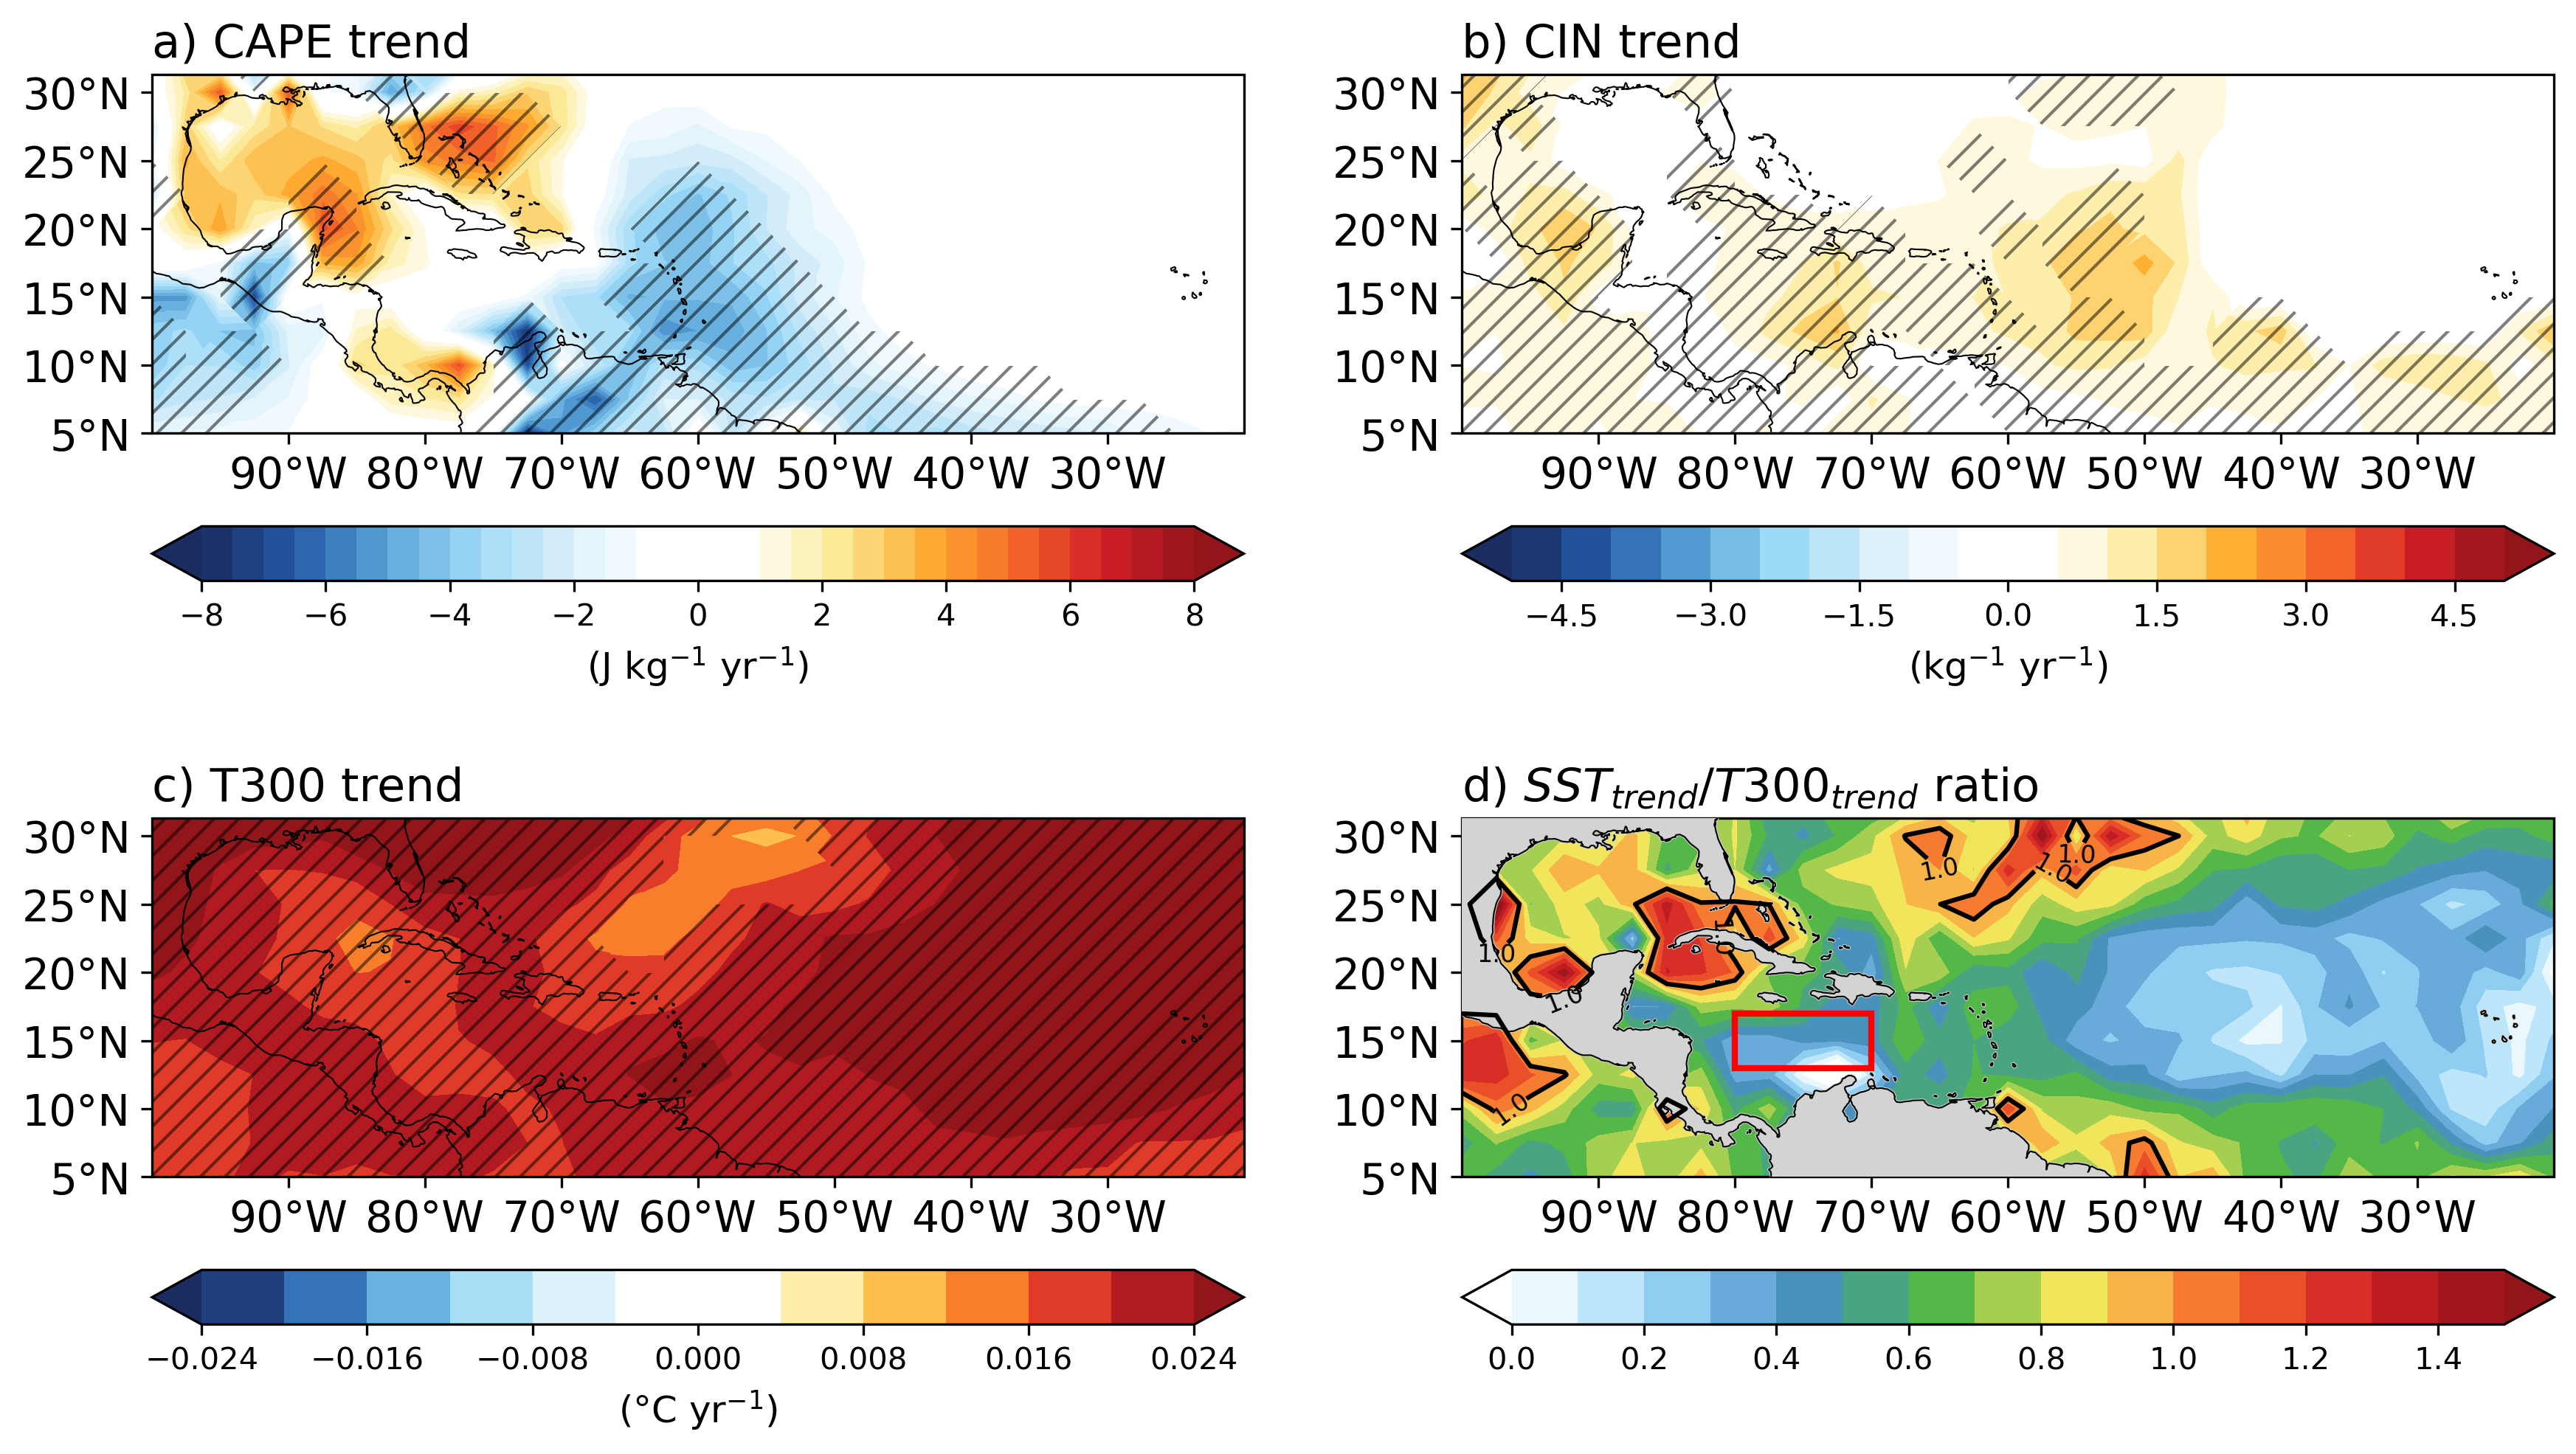

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

fig = plt.figure(figsize=(14, 8), dpi=300)
gs = gridspec.GridSpec(2, 2, figure=fig)

# Define subplots
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())


# --- Subplot 1 ---
# Set the extent for each subplot
ax1.set_extent([-100, -20, 5, 25])
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2, color='black')
ax1.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(axis='both', which='major', labelsize=14)

levels = np.arange(-8, 8.5, 0.5)
im = ax1.contourf(cape_trend_results.longitude.values,
                  cape_trend_results.latitude.values,
                  cape_trend_results.trend.values[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Mesh the entire grid
fill = ax1.fill_between(ax1.get_xlim(), *ax1.get_ylim(), color='none', edgecolor='black', lw=0, hatch=3*'/', alpha=0.5)

# Mask trend where p_value is less than 0.05
all_trends_revmask = np.where(cape_trend_results.p_value.values < 0.05, np.nan, cape_trend_results.trend.values)

# Plot the data for the current month
im = ax1.contourf(cape_trend_results.longitude.values,
                  cape_trend_results.latitude.values,
                  all_trends_revmask[:, :], levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Subplot titles
ax1.set_title('    CAPE$_{trend}$', loc='left')
ax1.text(0.01, 1.138, 'a', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add a single colorbar for all subplots
cb = plt.colorbar(im, orientation='horizontal')
cb.set_label('(J kg$^{-1}$ yr$^{-1}$)', fontsize=12)

# Add domain box for CLLJ
rect = plt.Rectangle((-80, 13), 10, 4, linewidth=2, edgecolor='xkcd:fire engine red', facecolor='none', zorder=4)
ax1.add_patch(rect)

# --- Subplot 2 ---
# Set the extent for each subplot
ax2.set_extent([-100, -20, 5, 25])
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2, color='black')
ax2.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Plot the data for the current month
levels = np.arange(-5, 5.5, 0.5)
im = ax2.contourf(cin_trend_results.longitude.values,
                  cin_trend_results.latitude.values,
                  cin_trend_results.trend.values[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both',
                  transform=ccrs.PlateCarree())

# Mesh the entire grid
fill = ax2.fill_between(ax2.get_xlim(), *ax2.get_ylim(), color='none', edgecolor='black', lw=0, hatch=3*'/', alpha=0.5)


# Mask trend where p_value is less than 0.05
all_trends_revmask = np.where(cin_trend_results.p_value.values < 0.05, np.nan, cin_trend_results.trend.values)

# Plot the data for the current month
im = ax2.contourf(cin_trend_results.longitude.values,
                  cin_trend_results.latitude.values,
                  all_trends_revmask[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both',
                  transform=ccrs.PlateCarree())

# Subplot titles
ax2.set_title('    CIN$_{trend}$', loc='left')
ax2.text(0.01, 1.138, 'b', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add a single colorbar for all subplots
cb = plt.colorbar(im, orientation='horizontal')
cb.set_label('(J kg$^{-1}$ yr$^{-1}$)', fontsize=12)

# Add domain box for CLLJ
rect = plt.Rectangle((-80, 13), 10, 4, linewidth=2, edgecolor='xkcd:fire engine red', facecolor='none', zorder=4)
ax2.add_patch(rect)

# --- Subplot 3 ---
ax3.set_extent([-100, -20, 5, 25])
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2, color='black')
ax3.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.tick_params(axis='both', which='major', labelsize=14)

# Plot the data for the current month
levels = np.arange(-0.04, 0.044, 0.004)
im = ax3.contourf(temp_trend_results.longitude.values,
                  temp_trend_results.latitude.values,
                  temp_trend_results.trend.values[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Mesh the entire grid
fill = ax3.fill_between(ax3.get_xlim(), *ax3.get_ylim(), color='none', edgecolor='black', lw=0, hatch=3*'/', alpha=0.5)

# Mask trend where p_value is less than 0.05
all_trends_revmask = np.where(temp_trend_results.p_value.values < 0.05, np.nan, temp_trend_results.trend.values)

# Plot the data for the current month
im = ax3.contourf(temp_trend_results.longitude.values,
                  temp_trend_results.latitude.values,
                  all_trends_revmask[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Subplot titles
ax3.set_title('    T300$_{trend}$', loc='left')
ax3.text(0.01, 1.138, 'c', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')


# Add a single colorbar for all subplots
cb = plt.colorbar(im, orientation='horizontal')
cb.set_label('(°C yr$^{-1}$)', fontsize=12)

# Add domain box for CLLJ
rect = plt.Rectangle((-80, 13), 10, 4, linewidth=2, edgecolor='white', facecolor='none', zorder=4)
ax3.add_patch(rect)

# --- Subplot 4 ---
ax4.set_extent([-100, -20, 5, 25])
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=4)
ax4.add_feature(cfeature.LAND, zorder=3, color='lightgray')
ax4.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.tick_params(axis='both', which='major', labelsize=14)

# Plot the data for the current month
levels = np.arange(0, 2.1, 0.1)
im = ax4.contourf(sst_temp_ratio.longitude.values,
                  sst_temp_ratio.latitude.values,
                  sst_temp_ratio.values[:, :],
                  levels=levels,
                  cmap=new_BrBG_r,
                  norm= colors.TwoSlopeNorm(vcenter=1, vmin=0, vmax=2),
                  extend='both', transform=ccrs.PlateCarree())

# Add contour to indicate a ratio of 1
cntr = ax4.contour(sst_temp_ratio.longitude.values,
                  sst_temp_ratio.latitude.values,
                  sst_temp_ratio.values[:, :],
                  levels=[1],
                  linewidth=2,
                  colors='black',
                  transform=ccrs.PlateCarree(),
                   zorder=3,
                  )

# Contour label
cntr.clabel(fmt='%1.1f', fontsize=8)

# Add domain box for CLLJ
rect = plt.Rectangle((-80, 13), 10, 4, linewidth=2, edgecolor='xkcd:fire engine red', facecolor='none', zorder=4)
ax4.add_patch(rect)

# Subplot titles
ax4.set_title('    $SST_{trend}/T300_{trend}$ ratio', loc='left')
ax4.text(0.01, 1.137, 'd', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')


# Add a single colorbar for all subplots
cb = plt.colorbar(im, orientation='horizontal', ticks=np.arange(0, 2.2, 0.2))

# Add annotations to subplot 4
ax4.annotate('More stable', xy=(-100,-15), xytext=(-100, -15), fontsize=12, )
ax4.annotate(' ', xy=(-65,-14), xytext=(-80, -14),
             arrowprops=dict(arrowstyle='<-', connectionstyle="angle,rad=0"),
             fontsize=12)

ax4.annotate('Less stable', xy=(-35,-15), xytext=(-35, -15), fontsize=12)
ax4.annotate(' ', xy=(-55,-14), xytext=(-40, -14),
             arrowprops=dict(arrowstyle='<-', connectionstyle="angle,rad=0"),
             fontsize=12)

# --- Save figure ---
fig.savefig('../figures/figure3.pdf', dpi=300, format='pdf', bbox_inches='tight')